# 인구 데이터 기반 소득 예측 경진대회

- 대회 링크 : https://dacon.io/competitions/official/235892/overview/description

- 목적 : 인구 데이터 바탕으로 소득이 5만달러 이하인지 초과인지 분류하기

- 데이터: 
  1. train.csv : 학습 데이터
  2. test.csv : 테스트 데이터
  3. sample_submission.csv : 제출 양식

## train data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 데이터 확인하기

In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab/data/train.csv')
train

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
0,0,32,Private,309513,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
1,1,33,Private,205469,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
2,2,46,Private,149949,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
3,3,23,Private,193090,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,0
4,4,55,Private,60193,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17475,17475,35,NaN,320084,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
17476,17476,30,NaN,33811,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
17477,17477,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1
17478,17478,41,NaN,202822,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,0


1. train.csv : 학습 데이터

- id : 샘플 아이디
- age : 나이
- workclass : 일 유형
- fnlwgt : CPS(Current Population Survey) 가중치
- education : 교육수준
- education.num : 교육수준 번호
- marital.status : 결혼 상태
- occupation : 직업
- relationship : 가족관계
- race : 인종
- sex : 성별
- capital.gain : 자본 이익
- capital.loss : 자본 손실
- hours.per.week : 주당 근무시간
- native.country : 본 국적
- target : 소득
					   0 = <=50K (5만 달러 이하)

					   1 = >50K (5만 달러 초과) 

###  결측치 확인하기

In [ ]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 있는 컬럼은: workclass 입니다
해당 컬럼에 총 1836 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: occupation 입니다
해당 컬럼에 총 1843 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: native.country 입니다
해당 컬럼에 총 583 개의 결측치가 존재합니다.


In [ ]:
print(train['workclass'].unique())
print(train['occupation'].unique())
print(train['native.country'].unique())

['Private' 'State-gov' 'Local-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Federal-gov' 'Without-pay' nan 'Never-worked']
['Craft-repair' 'Exec-managerial' 'Adm-clerical' 'Prof-specialty'
 'Machine-op-inspct' 'Other-service' 'Sales' 'Farming-fishing'
 'Transport-moving' 'Handlers-cleaners' 'Tech-support' 'Protective-serv'
 'Priv-house-serv' 'Armed-Forces' nan]
['United-States' 'Poland' 'Mexico' 'Ireland' 'Guatemala'
 'Dominican-Republic' 'Greece' 'El-Salvador' 'Portugal' 'Canada'
 'Philippines' 'India' 'Italy' 'England' 'Jamaica' 'Columbia' 'South'
 'Vietnam' 'Cuba' 'Laos' 'Hong' 'Haiti' 'Germany' 'Yugoslavia' 'Ecuador'
 'France' 'Puerto-Rico' 'Outlying-US(Guam-USVI-etc)' 'Taiwan' 'China'
 'Japan' 'Honduras' 'Peru' 'Nicaragua' 'Hungary' 'Cambodia' 'Iran'
 'Trinadad&Tobago' 'Thailand' 'Scotland' 'Holand-Netherlands' nan]


In [ ]:
# 결측치를 처리하는 함수를 작성합니다.
def handle_na(data, missing_col):
    temp = data.copy()
    for col, dtype in missing_col:
        if dtype == 'O':
            # 범주형 feature가 결측치인 경우 해당 행들을 삭제해 주었습니다.
            temp = temp.dropna(subset=[col])
    return temp

train = handle_na(train, missing_col)

# 결측치 처리가 잘 되었는지 확인해 줍니다.
missing_col = check_missing_col(train) 

결측치가 존재하지 않습니다


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15081 entries, 0 to 15080
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              15081 non-null  int64 
 1   age             15081 non-null  int64 
 2   workclass       15081 non-null  object
 3   fnlwgt          15081 non-null  int64 
 4   education       15081 non-null  object
 5   education.num   15081 non-null  int64 
 6   marital.status  15081 non-null  object
 7   occupation      15081 non-null  object
 8   relationship    15081 non-null  object
 9   race            15081 non-null  object
 10  sex             15081 non-null  object
 11  capital.gain    15081 non-null  int64 
 12  capital.loss    15081 non-null  int64 
 13  hours.per.week  15081 non-null  int64 
 14  native.country  15081 non-null  object
 15  target          15081 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 2.0+ MB


### 데이터 전처리

범주형 변수들을 라벨 인코딩

In [ ]:
#라벨인코딩을 하기 위함 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            #dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

train = label_encoder(train, make_label_map(train))

In [ ]:
train

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
0,0,32,0,309513,0,12,0,0,0,0,0,0,0,40,0,0
1,1,33,0,205469,1,10,0,1,0,0,0,0,0,40,0,1
2,2,46,0,149949,1,10,0,0,0,0,0,0,0,40,0,0
3,3,23,0,193090,2,13,1,2,1,0,1,0,0,30,0,0
4,4,55,0,60193,3,9,2,2,2,0,1,0,0,40,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15076,15076,35,0,337286,7,14,1,1,2,2,0,0,0,40,0,0
15077,15077,36,0,182074,1,10,2,2,2,0,0,0,0,45,0,0
15078,15078,50,4,175070,4,15,0,3,0,0,0,0,0,45,0,1
15079,15079,39,0,202937,1,10,2,10,2,0,1,0,0,40,1,0


### 모델 선언과 학습
- 변수 및 모델 정의

In [ ]:
# 분석에 필요 없는 id 와 예측하고자 하는 값 타겟을 제거해줍니다.
X = train.drop(['id','target'], axis=1)
y = train['target']

In [ ]:
from sklearn.linear_model import LogisticRegression

# 모델 선언
model = LogisticRegression(solver='liblinear')

# 모델 학습
model.fit(X, y)

LogisticRegression(solver='liblinear')

In [ ]:
# 먼저 점수를 메기는 방법인 평가 지표(Metric)를 정의합니다.
import numpy as np

def ACCURACY(true, pred):   
    score = np.mean(true==pred)
    return score

In [ ]:
# 모델의 예측과 실제 정답값을 비교합니다.
prediction = model.predict(X)

score = ACCURACY(y, prediction)

print(f"모델의 정확도는 {score*100:.2f}% 입니다")

모델의 정확도는 79.09% 입니다


#### train.csv 학습/검증셋 분리하기

In [ ]:
from sklearn.model_selection import train_test_split

data = train.drop('id', axis = 1).copy() #필요없는 id열 삭제
train_data, val_data = train_test_split(data, test_size=0.5)
train_data.reset_index(inplace=True) #전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화
val_data.reset_index(inplace=True)

In [ ]:
print( 'train 데이터 셋 모양 :', train_data.shape)
print( 'val 데이터 셋 모양 :', val_data.shape)

train 데이터 셋 모양 : (7540, 16)
val 데이터 셋 모양 : (7541, 16)


In [ ]:
train_data.head()

,index,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
0,8975,27,0,29904,2,13,1,10,2,0,1,0,0,40,0,0
1,6357,39,3,202027,4,15,0,3,0,0,0,0,1977,50,0,1
2,5418,21,0,191444,6,7,1,7,3,0,0,0,0,40,0,0
3,1931,22,0,215546,0,12,1,1,2,0,0,0,0,55,0,0
4,7742,61,0,28291,3,9,2,7,2,0,1,0,0,82,0,0


In [ ]:
X_train = train_data.drop(['index', 'target'], axis=1) #training 데이터에서 독립변수 추출
y_train = train_data.target #training 데이터에서 라벨 추출

In [ ]:
X_train.shape

(7540, 14)

In [ ]:
### 모델 학습
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier() # 모델을 객체에 할당
model.fit(X_train, y_train) # 모델 학습

#pred = model.predict(test)

RandomForestClassifier()

검증셋으로 모델 성능 검증

In [ ]:
X_val = val_data.drop(['index', 'target'], axis=1)  #validation 데이터에서 전처리된 문서 추출
y_val = val_data.target #validation 데이터에서 라벨 추출

In [ ]:
y_pred = model.predict(X_val)
print(y_pred)

[0 0 0 ... 1 1 0]


In [ ]:
from sklearn import metrics

print('RandomForestClassifier 의 예측 정확도는', round(metrics.accuracy_score(y_val, y_pred),3)) # 정확도 확인

RandomForestClassifier 의 예측 정확도는 0.845


#### 랜덤 포레스트 하이퍼 파라미터 튜닝

In [ ]:
### max_depth
from sklearn.ensemble import RandomForestClassifier

model_md1 = RandomForestClassifier(max_depth = 1) # 모델을 객체에 할당
model_md10 = RandomForestClassifier(max_depth = 10)

model_md1.fit(X_train, y_train) # 모델 학습
model_md10.fit(X_train, y_train) 

pred_md1 = model_md1.predict(X_val)
pred_md10 = model_md10.predict(X_val)

print('RF max_depth = 1 의 예측 정확도는', round(metrics.accuracy_score(y_val, pred_md1),3)) # 정확도 확인
print('RF max_depth = 10 의 예측 정확도는', round(metrics.accuracy_score(y_val, pred_md10),3)) # 정확도 확인

RF max_depth = 1 의 예측 정확도는 0.747
RF max_depth = 10 의 예측 정확도는 0.852


In [ ]:
### n_estimators
from sklearn.ensemble import RandomForestClassifier

model_ne1 = RandomForestClassifier(n_estimators = 1) # 모델을 객체에 할당
model_ne200 = RandomForestClassifier(n_estimators = 200)

model_ne1.fit(X_train, y_train) # 모델 학습
model_ne200.fit(X_train, y_train) 

pred_ne1 = model_ne1.predict(X_val)
pred_ne200 = model_ne200.predict(X_val)

print('RF n_estimators = 1 의 예측 정확도는', round(metrics.accuracy_score(y_val, pred_ne1),3)) # 정확도 확인
print('RF n_estimators = 200 의 예측 정확도는', round(metrics.accuracy_score(y_val, pred_ne200),3)) # 정확도 확인

RF n_estimators = 1 의 예측 정확도는 0.796
RF n_estimators = 200 의 예측 정확도는 0.845


In [ ]:
### max_features
from sklearn.ensemble import RandomForestClassifier

model_mf1 = RandomForestClassifier(max_features = 1) # 모델을 객체에 할당
model_mf3 = RandomForestClassifier(max_features = 3)

model_mf1.fit(X_train, y_train) # 모델 학습
model_mf3.fit(X_train, y_train) 

pred_mf1 = model_mf1.predict(X_val)
pred_mf3 = model_mf3.predict(X_val)

print('RF n_estimators = 1 의 예측 정확도는', round(metrics.accuracy_score(y_val, pred_mf1),3)) # 정확도 확인
print('RF n_estimators = 3 의 예측 정확도는', round(metrics.accuracy_score(y_val, pred_mf3),3)) # 정확도 확인

RF n_estimators = 1 의 예측 정확도는 0.846
RF n_estimators = 3 의 예측 정확도는 0.845


In [ ]:
model_2 = RandomForestClassifier(max_depth = 10, n_estimators = 200, max_features = 3) # 최종 모델
model_2.fit(X_train, y_train) 
y_pred_2 = model_2.predict(X_val)
print(y_pred_2)
print('Tuned RandomForestClassifier 의 예측 정확도는', round(metrics.accuracy_score(y_val, y_pred_2),3)) # 정확도 확인

[0 0 0 ... 1 1 0]
Tuned RandomForestClassifier 의 예측 정확도는 0.85


#### XGBoost

In [ ]:
import xgboost as xgb

# 모델 선언
model = xgb.XGBClassifier() 

# 모델 훈련
model.fit(X_train,y_train) 

# 모델 예측
y_pred_3 = model.predict(X_val) 

print(y_pred_3)
print('XGBoost의 예측 정확도는', round(metrics.accuracy_score(y_val, y_pred_3),3)) # 정확도 확인

[0 0 0 ... 1 1 0]
XGBoost의 예측 정확도는 0.855


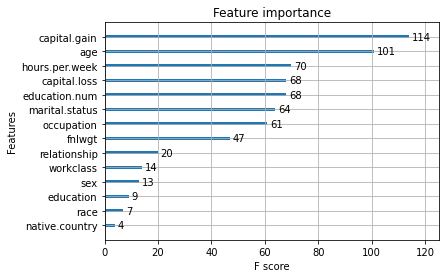

In [ ]:
xgb.plot_importance(model)

: xgb.plot_importance() 메쏘드에 XGBoost 모형객체를 넣어 변수중요도를 파악할 수 있다.

중요도가 높은 변수는 age : 나이와 capital.gain : 자본 이익인 것을 알 수 있다.

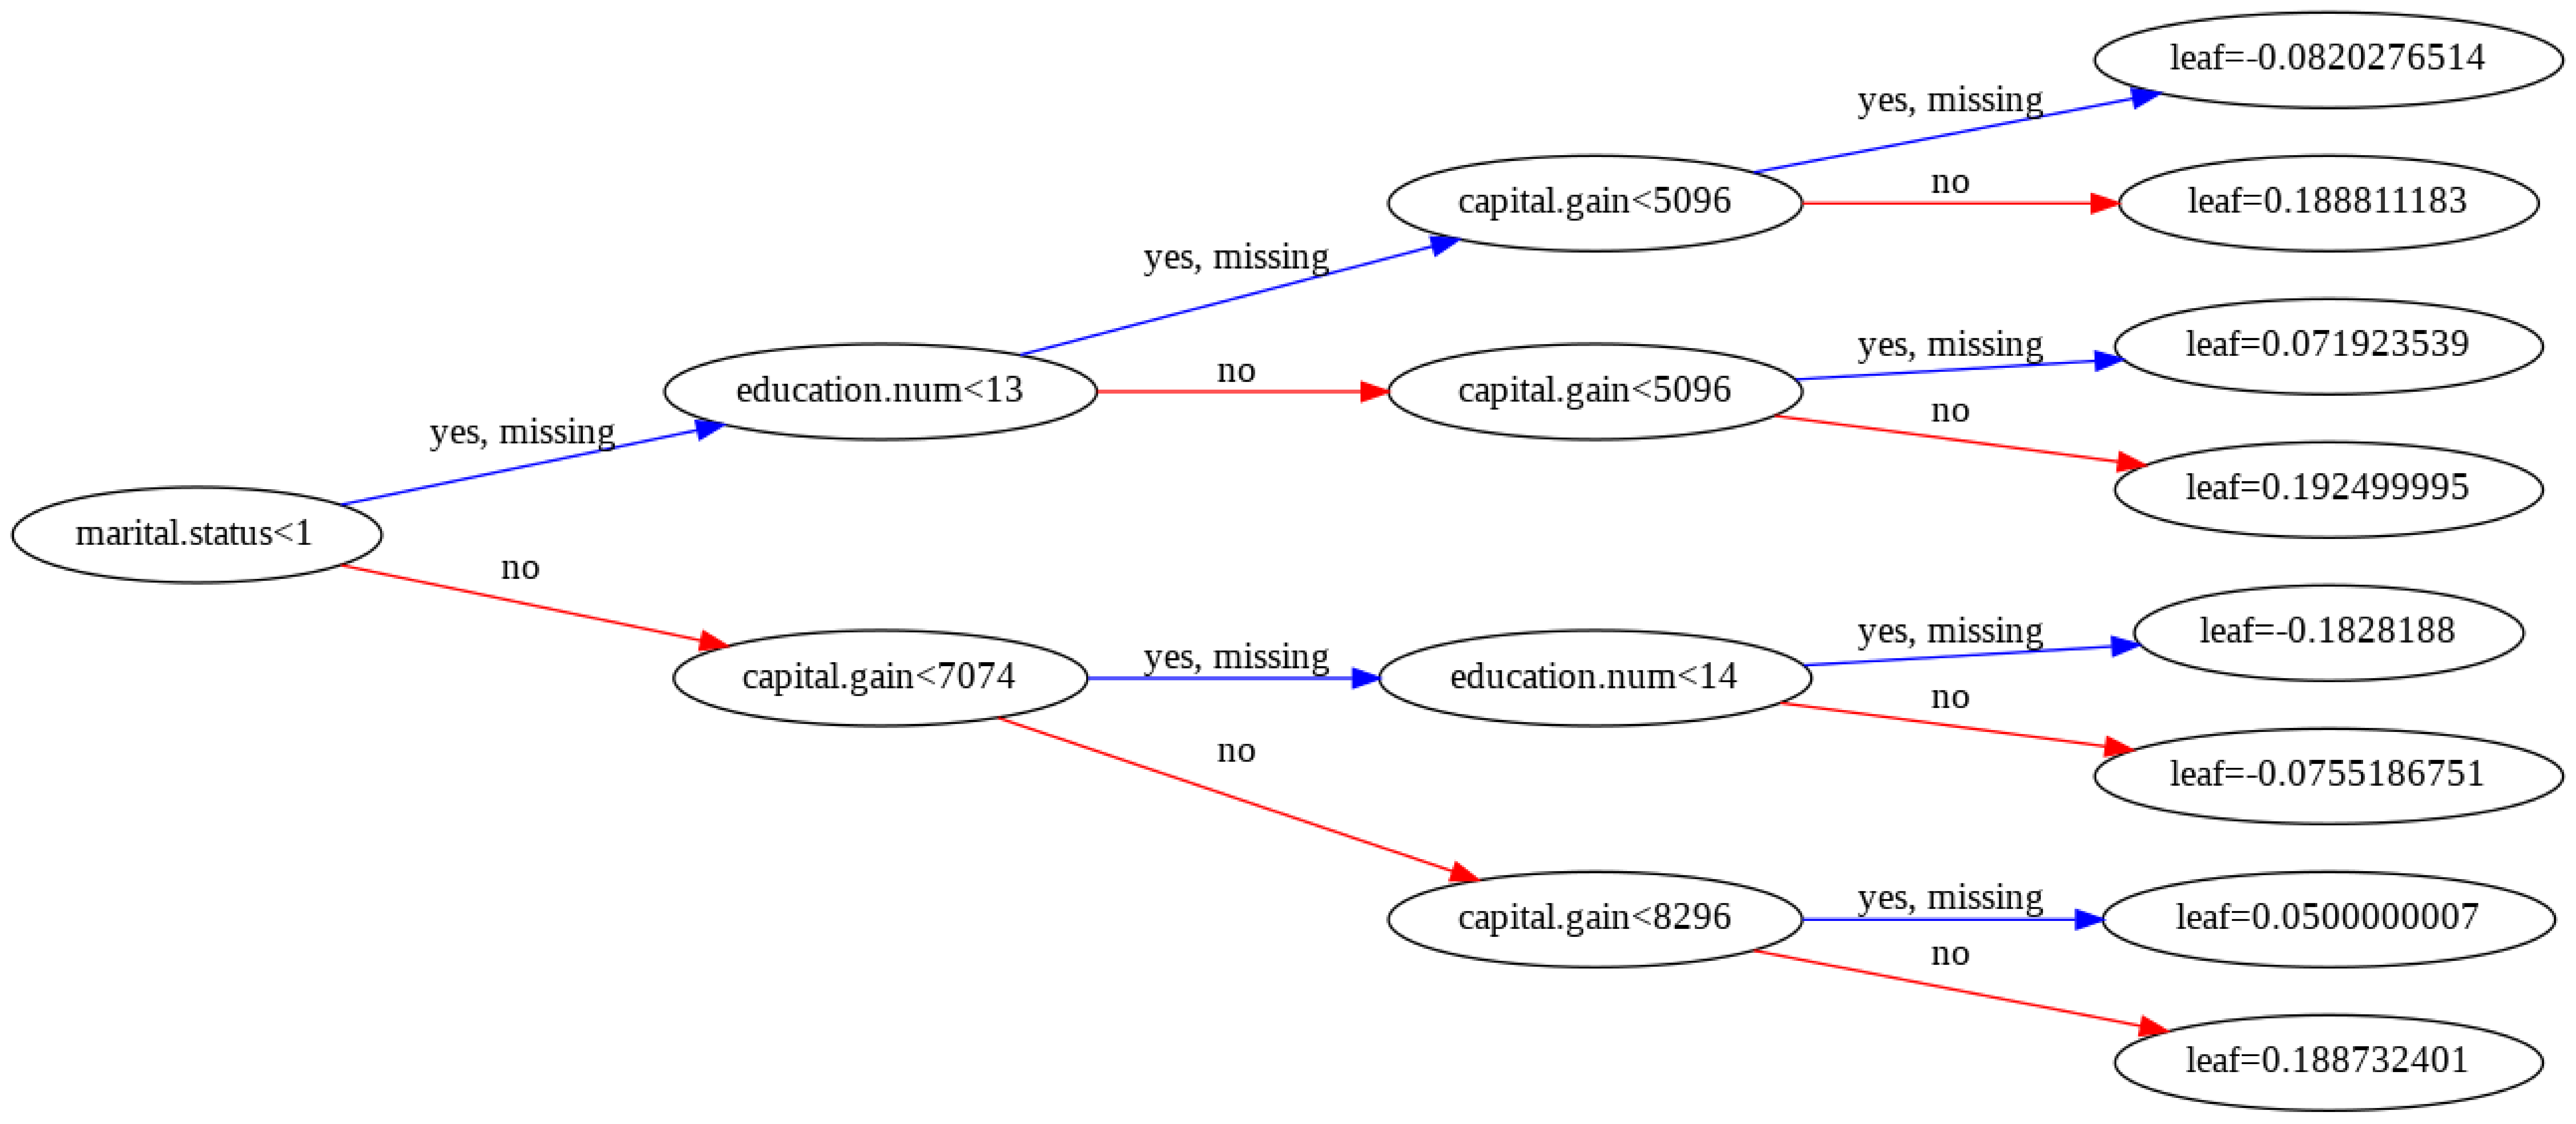

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(150, 100)

plt.show()

xgb.plot_importance(model)을 바탕으로 중요하지 않은 변수인 

    workclass : 일 유형, sex : 성별, education : 교육수준, race : 인종, native.country : 본 국적

를 제외시키고 XGBoost을 사용하여 분석해볼 것입니다.

In [ ]:
train_data.head()

,index,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
0,8975,27,0,29904,2,13,1,10,2,0,1,0,0,40,0,0
1,6357,39,3,202027,4,15,0,3,0,0,0,0,1977,50,0,1
2,5418,21,0,191444,6,7,1,7,3,0,0,0,0,40,0,0
3,1931,22,0,215546,0,12,1,1,2,0,0,0,0,55,0,0
4,7742,61,0,28291,3,9,2,7,2,0,1,0,0,82,0,0


In [ ]:
X_train_xg = train_data.drop(['index', 'target','workclass', 'sex', 'education', 'race', 'native.country','relationship'], axis=1) #training 데이터에서 독립변수 추출
y_train_xg = train_data.target #training 데이터에서 라벨 추출

In [ ]:
val_data.head()

,index,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
0,9533,49,0,31807,1,10,1,1,3,0,1,0,0,40,0,0
1,10785,48,0,149640,3,9,0,8,0,0,0,0,0,40,0,0
2,9413,42,0,34278,1,10,0,6,0,0,0,0,0,50,0,1
3,13561,30,0,206322,3,9,0,8,0,0,0,0,0,73,0,1
4,11330,28,0,38309,10,11,0,2,0,0,0,2407,0,40,0,0


In [ ]:
X_val_xg = val_data.drop(['index', 'target','workclass', 'sex', 'education', 'race', 'native.country','relationship'], axis=1)  #validation 데이터에서 전처리된 문서 추출
y_val_xg = val_data.target #validation 데이터에서 라벨 추출

In [ ]:
import xgboost as xgb

# 모델 선언
model = xgb.XGBClassifier() 

# 모델 훈련
model.fit(X_train_xg,y_train_xg) 

# 모델 예측
y_pred_4 = model.predict(X_val_xg) 

print(y_pred_4)
print('XGBoost의 예측 정확도는', round(metrics.accuracy_score(y_val_xg, y_pred_4),3)) # 정확도 확인

[0 0 0 ... 1 1 0]
XGBoost의 예측 정확도는 0.854


위에서 했던 xgboost 보다 예측 정확도가 0.001가 낮아졌습니다.  


그러면, target과 다른 변수들의 상관관계를 살펴본 후,
변수를 제거하여 다시 xgboost로 모델을 훈련해 보겠습니다.

In [ ]:
corr_matrix = train_data.corr()

corr_matrix["target"].sort_values(ascending=False)

target            1.000000
education.num     0.334992
age               0.256567
hours.per.week    0.241954
capital.gain      0.226078
workclass         0.148656
capital.loss      0.140511
fnlwgt            0.004013
native.country   -0.005655
education        -0.006617
index            -0.011621
race             -0.070404
occupation       -0.119528
sex              -0.214647
relationship     -0.238034
marital.status   -0.265266
Name: target, dtype: float64

train data의 target과 다른 변수들의 상관관계를 살펴봤을 때, 
1에 가까워 양의 관계를 가지고 있는 변수들은 

    education.num     0.334992
    age               0.256567
    hours.per.week    0.241954
    capital.gain      0.226078

이고,  -1에 가까워 응의 관계를 가지고 있는 변수들은 

    sex              -0.214647
    relationship     -0.238034
    marital.status   -0.265266

입니다. 상관계수가 0에 가깝게 나오는 변수들을 target과의 선형관계가 없기때문에 제거하고 모델을 훈련해볼 것입니다.

In [ ]:
X_train_cor = train_data.drop(['index', 'target','workclass', 'capital.loss', 'education', 'race', 'native.country','fnlwgt','occupation'], axis=1) #training 데이터에서 독립변수 추출
y_train_cor = train_data.target #training 데이터에서 라벨 추출

In [ ]:
X_val_cor = val_data.drop(['index', 'target','workclass', 'capital.loss', 'education', 'race', 'native.country','fnlwgt','occupation'], axis=1)  #validation 데이터에서 전처리된 문서 추출
y_val_cor = val_data.target #validation 데이터에서 라벨 추출

In [ ]:
import xgboost as xgb

# 모델 선언
model = xgb.XGBClassifier() 

# 모델 훈련
model.fit(X_train_cor,y_train_cor) 

# 모델 예측
y_pred_5 = model.predict(X_val_cor) 

print(y_pred_5)
print('XGBoost의 예측 정확도는', round(metrics.accuracy_score(y_val_cor, y_pred_5),3)) # 정확도 확인

[0 0 1 ... 1 1 0]
XGBoost의 예측 정확도는 0.846


위에서 했던 xgboost 보다 예측 정확도가 0.008가 낮아졌습니다.

xgboost로 모델을 훈련시키기에는 제일 첫번째에 했던 train_data를 사용해서 하는 것이 좋다고 판단했습니다.

#### LightGBM

## test data

- 변수 및 모델정리

In [ ]:
# csv형식으로 된 데이터 파일을 읽어옵니다.
test = pd.read_csv('/content/drive/MyDrive/Colab/data/test.csv')
test.head()

,id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0,47,Private,304133,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
1,1,34,Self-emp-inc,154227,Some-college,10,Never-married,Sales,Not-in-family,White,Male,0,0,75,United-States
2,2,31,Local-gov,158291,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,8614,0,40,United-States
3,3,28,Private,183155,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,55,United-States
4,4,54,Local-gov,182543,Some-college,10,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,Mexico


In [ ]:
test = label_encoder(test, make_label_map(test))
test = test.drop(['id'],axis=1)
test.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,47,0,304133,0,10,0,0,0,0,0,0,0,45,0
1,34,1,154227,0,10,1,1,1,0,0,0,0,75,0
2,31,2,158291,1,13,1,2,1,0,0,8614,0,40,0
3,28,0,183155,1,13,0,3,0,0,0,0,0,55,0
4,54,2,182543,0,10,2,4,2,0,1,0,0,40,1


In [ ]:
# 전처리가 완료된 테스트 데이터셋을 통해 본격적으로 학습한 모델로 추론을 시작합니다.
prediction = model.predict(test)
prediction

array([1, 0, 1, ..., 0, 0, 0])

- 랜덤 포레스트 하이퍼 파라미터 튜닝

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Colab/data/test.csv')
test = label_encoder(test, make_label_map(test))
test = test.drop('id', axis=1)
test.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,47,0,304133,0,10,0,0,0,0,0,0,0,45,0
1,34,1,154227,0,10,1,1,1,0,0,0,0,75,0
2,31,2,158291,1,13,1,2,1,0,0,8614,0,40,0
3,28,0,183155,1,13,0,3,0,0,0,0,0,55,0
4,54,2,182543,0,10,2,4,2,0,1,0,0,40,1


In [ ]:
X_train= data.drop(['target'], axis=1) #전체 training 데이터에서 독립변수 추출
y_train = data.target #전체 training 데이터에서 라벨 추출

In [ ]:
### RandomForestClassifier
model = RandomForestClassifier(max_depth = 10, n_estimators = 200, max_features = 3) #앞서 튜닝한 하이퍼 파라미터 max_depth, n_estimators, max_features
model.fit(X_train, y_train) 
y_pred = model.predict(test)

In [ ]:
### XGBoost Classifier
import xgboost as xgb

model = xgb.XGBClassifier() 
model.fit(X_train,y_train) 
y_pred = model.predict(test) 

## Dacon 대회에 제출하기 (Submission)

In [ ]:
# 제출용 Sample 파일을 불러옵니다
submission = pd.read_csv('/content/drive/MyDrive/Colab/data/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
submission['target'] = prediction

# 데이터가 잘 들어갔는지 확인합니다
submission

,id,target
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0
...,...,...
15076,15076,1
15077,15077,1
15078,15078,0
15079,15079,0


In [ ]:
# csv 파일 만들기
submission.to_csv('submit.csv', index=False)